In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    return np.pad(X, ((0, 0), (pad, pad), (pad, pad),(0,0)), 'constant',constant_values=(0, 0))

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


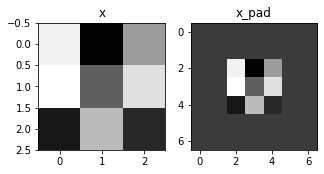

In [3]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

# Single Step Convolution

In [4]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    return Z + float(b)
    

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


In [12]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C)  = W.shape
    s , p = hparameters['stride'], hparameters['pad']

    n_h = int(int(n_H_prev + 2*p - f)/s + 1)
    n_w = int(int(n_W_prev + 2*p - f)/s + 1)

    Z = np.zeros([m, n_h, n_w, n_C])

    A_prev_pad = zero_pad(A_prev, p)
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_h):
            vert_start = s * h
            vert_end = vert_start + f

            for w in range(n_w):
                horiz_start = s*w
                horiz_end = horiz_start + f

                for c in range(n_C):
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    assert(Z.shape == (m, n_h, n_w, n_C))
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache



In [13]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


# Pooling

In [17]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f , stride = hparameters["f"], hparameters["stride"]

    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_c = n_C_prev

    A = np.zeros((m, n_H, n_W, n_c))
    for i in range(m):
      for h in range(n_H):
        vert_start = stride * h
        vert_end = vert_start + f
        for v in range(n_W):
          horiz_start = stride * v
          horiz_end = horiz_start + f
          for c in range(n_c):
            a_prev_slice = A_prev[i]
            if mode == 'max':
              A[i, h, v, c] = np.max(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
            elif mode == 'average':
              A[i, h, v, c] = np.mean(a_prev_slice[vert_start:vert_end, horiz_start:horiz_end, c])
    cache = (A_prev, hparameters)
    
    # Making sure your output shape is correct
    assert(A.shape == (m, n_H, n_W, n_c))
    
    return A, cache



In [18]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

In [19]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]
